In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import peak_prominences, find_peaks
import warnings
from sklearn.model_selection import KFold
import random

In [2]:
with open(f'/repos/Delivery-Readiness/data/raw_data_with_missingness/selected_feature_set_d.pkl', 'rb') as handle:
    data = pickle.load(handle)

In [3]:
features = [x for x in list(data.keys()) if x not in ['user_id', 'missingness']]

In [4]:
features

['duration', 'deep', 'rem', 'hr_average', 'total', 'efficiency']

In [5]:
def peak_prominences_(distances):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        all_peak_prom = peak_prominences(distances, range(len(distances)))
    return all_peak_prom

def post_processing(score, threshold):
        score_peaks = peak_prominences_(np.array(score))[0]
        for j in range(len(score_peaks)):
            if peak_prominences_(np.array(score))[0][j] - peak_prominences_(np.array(score))[0][j-1] >threshold :
                score_peaks[j] = 1
            else:
                score_peaks[j] = 0
        return score_peaks

In [56]:
before_days = 30
after_days = 7
x = list(range(-before_days+1, 7+1))
for i in range(len(data['user_id'])):
    user_id = int(data['user_id'][i])
    plt.rcParams["figure.figsize"] = (20,3)
    # plot features
    for feature in features:
        plt.plot(x, np.array(data[feature][i]) / np.nanmax(np.array(data[feature][i])), '-o', label=feature, alpha=0.2)
    plt.axvline(x=0, color='mediumpurple', ls='--', label='birth date', linewidth=2.5)
    try:
        # plot cpd score
        with open(f'/repos/TiVaCPD/TiVaCPD/out2/selected_feature_set_d/bump_user_{user_id}/mmd_score_0.pkl', 'rb') as handle:
            mmd_score = pickle.load(handle)
        with open(f'/repos/TiVaCPD/TiVaCPD/out2/selected_feature_set_d/bump_user_{user_id}/corr_score_0.pkl', 'rb') as handle:
            coor_score = pickle.load(handle)
        cpd_score = mmd_score + coor_score
        plt.plot(x, cpd_score, label='CPD Score', color='grey', linewidth=3.5)
        threshold = max(cpd_score) / 4
        peak_score = post_processing(cpd_score, threshold)
        peaks = np.array(peak_score).nonzero()[0]
        # plt.plot(peak_score, label='Peaks', color='grey', linewidth=2.5)
        plt.plot(peaks-before_days+1, cpd_score[peaks], ".", color="mediumpurple", linewidth=3.5, markersize=20)
        plt.xticks
    except:
        print(f"user id {user_id} isn't ready")
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.title(f"User ID: {user_id}, Missingness: {round((1 - data['missingness'][i]) * 100)} %")
    plt.savefig(f"/repos/Delivery-Readiness/vis_results/user_id_{user_id}-missingness_{data['missingness'][i] * 100}.png")
    # plt.show()
    plt.close()
    # break
    

user id 95 isn't ready


In [49]:
with open(f'/repos/Delivery-Readiness/data/selected_feature_set_d/bump_user_42/user_original_0.pkl', 'rb') as handle:
    test = pickle.load(handle)
    print(test.shape)

(37, 6)


In [9]:
with open(f'/repos/Delivery-Readiness/data/daily_new_split_non_schedule/largest_window/test_0.pickle', 'rb') as handle:
    test = pickle.load(handle)
    print(test.keys())
    print(test['X'].shape)

dict_keys(['X', 'y', 'uid', 'start_date', 'feature_name'])
(13, 7, 3)


In [6]:
len(data['user_id'])

42

In [15]:
before_days = 30
after_days = 7
count = 0
missingness_correct = []
missingness_incorrect = []
all_users = list(set(data['user_id']))
kf_both = KFold(n_splits=10, random_state=0, shuffle=True)
for fold_i, (train_index, test_index) in enumerate(kf_both.split(all_users)):
    train_ids = list(np.array(all_users)[train_index]) # user ids of training 
    test_ids = list(np.array(all_users)[test_index]) # user ids of testing
    # print(train_ids)
    # print(test_ids)

    train_readliness_data = {'X': [], 'y': [], 'uid': [], 'readiness_date': [], 'feature_name': features}
    for i in train_index:
        user_id = int(data['user_id'][i])
        missingness = data['missingness'][i]
        each_data = np.zeros((before_days + after_days, len(features)))
        for j, feature in enumerate(features):
            each_data[:,j] = np.array(data[feature][i])
        try:
            # plot cpd score
            with open(f'/repos/TiVaCPD/TiVaCPD/out2/selected_feature_set_d/bump_user_{user_id}/mmd_score_0.pkl', 'rb') as handle:
                mmd_score = pickle.load(handle)
            with open(f'/repos/TiVaCPD/TiVaCPD/out2/selected_feature_set_d/bump_user_{user_id}/corr_score_0.pkl', 'rb') as handle:
                coor_score = pickle.load(handle)
            cpd_score = mmd_score + coor_score
            threshold = max(cpd_score) / 4
            peak_score = post_processing(cpd_score, threshold)
            peaks, _ = find_peaks(peak_score)
            if before_days in peaks or before_days - 1 in peaks or before_days - 2 in peaks:
                count += 1
                missingness_correct.append(missingness)
            else:
                missingness_incorrect.append(missingness)
            filtered_peaks = [x for x in peaks if x < before_days - 2]

            selected_peak = -1
            readiness_peak = filtered_peaks[selected_peak]
            while np.isnan(each_data[readiness_peak-3:readiness_peak+4,:]).any():
                selected_peak -= 1
                readiness_peak = filtered_peaks[selected_peak]
            if readiness_peak > before_days - 14 - 1:
            # readiness_peak = random.randint(3, before_days-1-3)
            # while np.isnan(each_data[readiness_peak-3:readiness_peak+4,:]).any():
            #     readiness_peak = random.randint(3, before_days-1-3)
                non_readiness_window = each_data[readiness_peak-3:readiness_peak,:].T
                readiness_window = each_data[readiness_peak+1:readiness_peak+4,:].T
                train_readliness_data['X'].append(readiness_window)
                train_readliness_data['y'].append(1)
                train_readliness_data['uid'].append(user_id)
                train_readliness_data['readiness_date'].append(readiness_peak - before_days + 1)
                train_readliness_data['X'].append(non_readiness_window)
                train_readliness_data['y'].append(0)
                train_readliness_data['uid'].append(user_id)
                train_readliness_data['readiness_date'].append(readiness_peak - before_days + 1)
            else:
                print(f"user id {user_id} isn't ready!!!")
        except:
            print(f"user id {user_id} isn't ready")
    train_readliness_data['X'] = np.stack(train_readliness_data['X'])
    with open(f'/repos/Delivery-Readiness/data/daily_selected_feature_set_d_readiness/train_{fold_i}.pickle', 'wb') as handle:
        pickle.dump(train_readliness_data, handle)

    test_readliness_data = {'X': [], 'y': [], 'uid': [], 'readiness_date': [], 'feature_name': features}
    for i in test_index:
        user_id = int(data['user_id'][i])
        missingness = data['missingness'][i]
        each_data = np.zeros((before_days + after_days, len(features)))
        for j, feature in enumerate(features):
            each_data[:,j] = np.array(data[feature][i])
        try:
            # plot cpd score
            with open(f'/repos/TiVaCPD/TiVaCPD/out2/selected_feature_set_d/bump_user_{user_id}/mmd_score_0.pkl', 'rb') as handle:
                mmd_score = pickle.load(handle)
            with open(f'/repos/TiVaCPD/TiVaCPD/out2/selected_feature_set_d/bump_user_{user_id}/corr_score_0.pkl', 'rb') as handle:
                coor_score = pickle.load(handle)
            cpd_score = mmd_score + coor_score
            threshold = max(cpd_score) / 4
            peak_score = post_processing(cpd_score, threshold)
            peaks, _ = find_peaks(peak_score)
            if before_days in peaks or before_days - 1 in peaks or before_days - 2 in peaks:
                count += 1
                missingness_correct.append(missingness)
            else:
                missingness_incorrect.append(missingness)
            filtered_peaks = [x for x in peaks if x < before_days - 2]

            selected_peak = -1
            readiness_peak = filtered_peaks[selected_peak]
            while np.isnan(each_data[readiness_peak-3:readiness_peak+4,:]).any():
                selected_peak -= 1
                readiness_peak = filtered_peaks[selected_peak]
            if readiness_peak > before_days - 14 - 1:
                # readiness_peak = random.randint(3, before_days-1-3)
                # while np.isnan(each_data[readiness_peak-3:readiness_peak+4,:]).any():
                #     readiness_peak = random.randint(3, before_days-1-3)
                non_readiness_window = each_data[readiness_peak-3:readiness_peak, :].T
                readiness_window = each_data[readiness_peak+1:readiness_peak+4,:].T
                test_readliness_data['X'].append(readiness_window)
                test_readliness_data['y'].append(1)
                test_readliness_data['uid'].append(user_id)
                test_readliness_data['readiness_date'].append(readiness_peak - before_days + 1)
                test_readliness_data['X'].append(non_readiness_window)
                test_readliness_data['y'].append(0)
                test_readliness_data['uid'].append(user_id)
                test_readliness_data['readiness_date'].append(readiness_peak - before_days + 1)
            else:
                print(f"user id {user_id} isn't ready!!!")
        except:
            print(f"user id {user_id} isn't ready")
    test_readliness_data['X'] = np.stack(test_readliness_data['X'])
    with open(f'/repos/Delivery-Readiness/data/daily_selected_feature_set_d_readiness/test_{fold_i}.pickle', 'wb') as handle:
        pickle.dump(test_readliness_data, handle)


user id 95 isn't ready
user id 159 isn't ready!!!
user id 190 isn't ready!!!
user id 1723 isn't ready!!!
user id 1387 isn't ready!!!
user id 95 isn't ready
user id 159 isn't ready!!!
user id 190 isn't ready!!!
user id 1723 isn't ready!!!
user id 1387 isn't ready!!!
user id 95 isn't ready
user id 159 isn't ready!!!
user id 190 isn't ready!!!
user id 1723 isn't ready!!!
user id 1387 isn't ready!!!
user id 95 isn't ready
user id 159 isn't ready!!!
user id 190 isn't ready!!!
user id 1723 isn't ready!!!
user id 1387 isn't ready!!!
user id 95 isn't ready
user id 159 isn't ready!!!
user id 1387 isn't ready!!!
user id 190 isn't ready!!!
user id 1723 isn't ready!!!
user id 95 isn't ready
user id 159 isn't ready!!!
user id 190 isn't ready!!!
user id 1723 isn't ready!!!
user id 1387 isn't ready!!!
user id 95 isn't ready
user id 159 isn't ready!!!
user id 190 isn't ready!!!
user id 1723 isn't ready!!!
user id 1387 isn't ready!!!
user id 95 isn't ready
user id 159 isn't ready!!!
user id 190 isn't r

In [11]:
filtered_peaks

NameError: name 'filtered_peaks' is not defined

In [32]:
count

16

In [35]:
missingness_incorrect

[0.89,
 0.81,
 0.86,
 0.89,
 0.97,
 0.86,
 0.81,
 0.95,
 0.86,
 0.84,
 0.95,
 0.92,
 0.97,
 0.95,
 0.81,
 0.86,
 0.81,
 0.84,
 0.81,
 0.92,
 0.84,
 0.89,
 0.92,
 0.92,
 0.92]

In [34]:
print(np.array(missingness_correct).mean())
print(np.array(missingness_incorrect).mean())

0.90125
0.8828


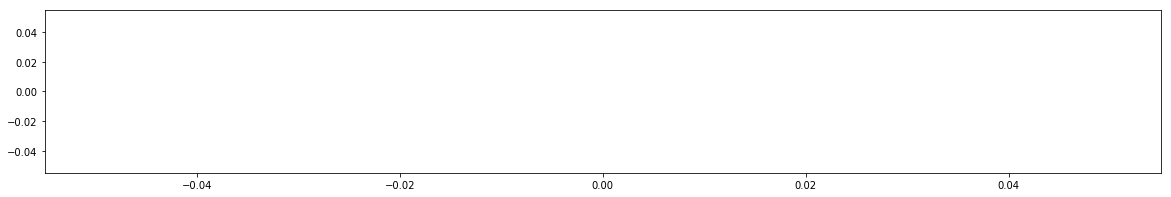

In [14]:
for feature in features:
    plt.plot(np.array(data[feature][3]) / max(data[feature][3]), label=feature)
plt.show()

In [8]:
data['duration'][3]

[nan,
 nan,
 nan,
 29760.0,
 31980.0,
 31860.0,
 34320.0,
 33480.0,
 32940.0,
 23280.0,
 29040.0,
 33540.0,
 32220.0,
 37740.0,
 37980.0,
 33780.0,
 35040.0,
 32040.0,
 32640.0,
 27480.0,
 38820.0,
 34800.0,
 34680.0,
 35880.0,
 38160.0,
 35520.0,
 35160.0,
 34320.0,
 29700.0,
 nan,
 nan,
 nan,
 30420.0,
 23220.0,
 33180.0,
 27300.0,
 30840.0]